# Drinkwaterwinning Bleijerheide



# Analyse reeks Maastricht

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pyextremes

## Instellingen

In [6]:
read=False # moeten de ruwe bestanden worden ingelezen?
drempel = 0.1 # mm - lager dan dit is 'droog'
prec_hours = 24. # na een droogte tellen we de neerslag op over de eerste 24 uur
min_duration = 3*24 # we nemen alleen droogtes mee die langer duren dan 7 dagen

### Inlezen data

Inlezen van data: als True worden de ruwe KNMI files inglezen, als False een tijdelijke (snellere) file met alleen de uur-reeks.

In [7]:
if read:
    files = os.listdir('brondata')
    alldata = pd.DataFrame()
    for file in files:    
        print(file)
        data = pd.read_csv(os.path.join('brondata',file), skiprows=31)
        data.columns = [col.strip() for col in data.columns]
        data = data[data['RH'] != '     ']
        data.index = pd.to_datetime([f"{d.YYYYMMDD}{d.HH-1:02d}" for _,d in data.iterrows()],format='%Y%m%d%H')
        data['P'] = [float(d.RH)/10. for _,d in data.iterrows()]
        data = data[['P']]
        if len(data) ==0:
            alldata = data
        else:
            alldata = pd.concat([alldata, data], axis=0)
    alldata.to_csv(r'brondata\alle_data.csv')
else:    
    alldata  = pd.read_csv(r'brondata\alle_data.csv')
    alldata.index = pd.to_datetime(alldata.iloc[:,0])

Zo ziet de reeks eruit tussen 1957 en 2023:

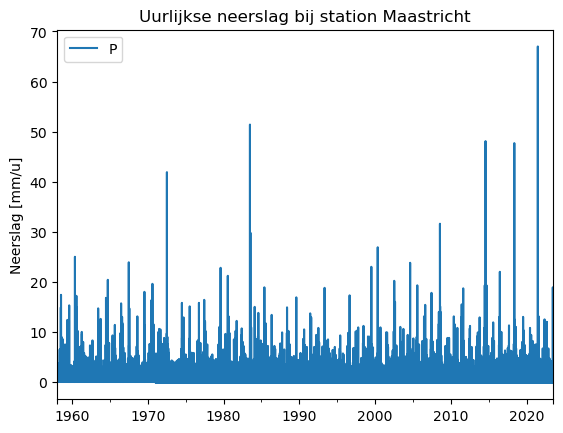

In [9]:
ax = alldata.plot()
ax.set_xlabel('')
ax.set_ylabel('Neerslag [mm/u]')
ax.set_title('Uurlijkse neerslag bij station Maastricht')
plt.savefig(r'figuren\helereeks_uurlijks.png')

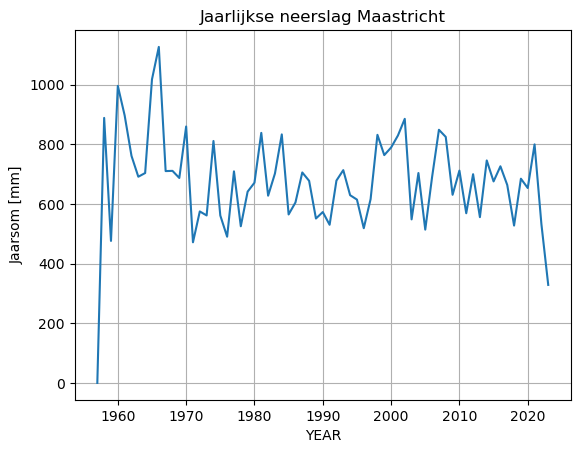

In [10]:
alldata['YEAR'] = alldata.index.year
jaarsommen = alldata.groupby('YEAR').sum()['P']
ax = plt.subplot()
jaarsommen.plot()
ax.set_ylabel('Jaarsom [mm]')
ax.set_title('Jaarlijkse neerslag Maastricht')
ax.grid()
plt.savefig(r'figuren\helereeks_jaarlijks.png')

In [11]:
alldata.to_csv(r'tabellen\alle_neerslagdata.csv',index=False, sep=",")

### Verzamel statistieken

In [12]:
duration = []
prec_after = []
years = []
endd = []
n_event=0
duration.append(0)
prec_after.append(0.)
years.append(0)
endd.append(0)
for year in alldata.index.year.unique():
    subset = alldata[alldata.index.year == year]
    subset.loc[subset['P'] < drempel, 'P'] = 0.
    subset['dry'] = (subset.P == 0.)
    subset['crossing'] = (subset.dry != subset.dry.shift()).cumsum()
    subset['count'] = subset.groupby(['dry', 'crossing']).cumcount(ascending=False) + 1
    subset.loc[subset.dry == False, 'count'] = 0
    subset.loc[subset['dry'],'drynum'] = 1
    subset.loc[~subset['dry'],'drynum'] = 0
    for ind,dat in subset.iterrows():
        if dat.dry:
            duration[n_event]+=1
        else:    
            n_event += 1
            duration.append(0)
            prec_after.append(0)
            years.append(0)
            endd.append(0)
            prec_after[n_event-1] = subset.loc[ind:ind+pd.Timedelta(hours=prec_hours),'P'].sum()
            years[n_event-1] = year
            endd[n_event-1] = ind            

En stop ze in een dataframe

In [13]:
results = [(s,p,d,y) for s,p,d,y in zip(endd, years, duration, prec_after) if d >= min_duration]
resdf = pd.DataFrame(results)
resdf.columns = ['Enddate', 'Year','Duration','Precipitation']     
resdf.index = resdf['Enddate']
resdf.loc[:,'Duration'] = resdf.Duration / 24.
resdf

,Enddate,Year,Duration,Precipitation
Enddate,,,,
1958-01-31 04:00:00,1958-01-31 04:00:00,1958,3.583333,0.3
1958-03-02 10:00:00,1958-03-02 10:00:00,1958,3.000000,0.9
1958-03-05 19:00:00,1958-03-05 19:00:00,1958,3.083333,4.3
1958-03-20 09:00:00,1958-03-20 09:00:00,1958,5.125000,0.5
1958-03-26 09:00:00,1958-03-26 09:00:00,1958,3.875000,1.4
...,...,...,...,...
2023-04-20 11:00:00,2023-04-20 11:00:00,2023,3.166667,1.2
2023-04-28 00:00:00,2023-04-28 00:00:00,2023,3.583333,2.6
2023-05-05 10:00:00,2023-05-05 10:00:00,2023,3.625000,0.4


In [14]:
resdf.to_csv(r'tabellen\alle_drooogte_gebeurtenissen.csv', index=False, sep=",")

Bovenstaande tabel bevat alle events met een duur langer dan 'min_duration' (nu 3 dagen). De startdatum van het event; het jaar, de duur (in dagen) en de neerslag in de 24-uur eropvolgend.

Plot de duur in uren van alle droogte events. Juni 2023 is best wel extreem....

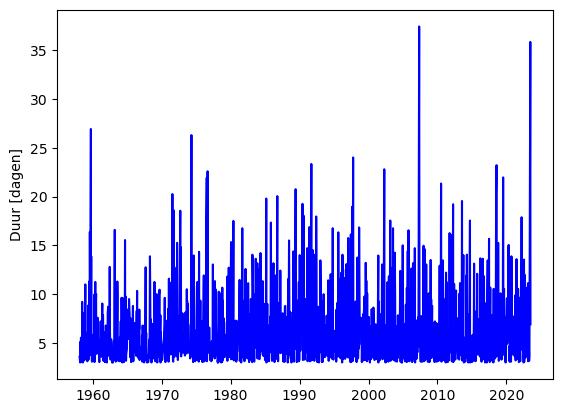

In [15]:
ax = plt.subplot()
ax.plot(resdf.index, resdf.Duration, color='blue')
ax.set_ylabel('Duur [dagen]')
plt.savefig(r'figuren\droogte_gebeurtenissen.png')

Dit zijn de langste - april/mei 2007 heeft het record: 37 dagen.

In [17]:
resdf[resdf.Duration > 25]

,Enddate,Year,Duration,Precipitation
Enddate,,,,
1959-09-22 04:00:00,1959-09-22 04:00:00,1959,26.916667,4.0
1974-04-23 13:00:00,1974-04-23 13:00:00,1974,26.291667,5.9
2007-05-07 03:00:00,2007-05-07 03:00:00,2007,37.416667,8.9
2023-06-20 19:00:00,2023-06-20 19:00:00,2023,35.833333,5.3


Is er een relatie tussen de duur en de eropvolgende neerslag? We verwachten het niet.

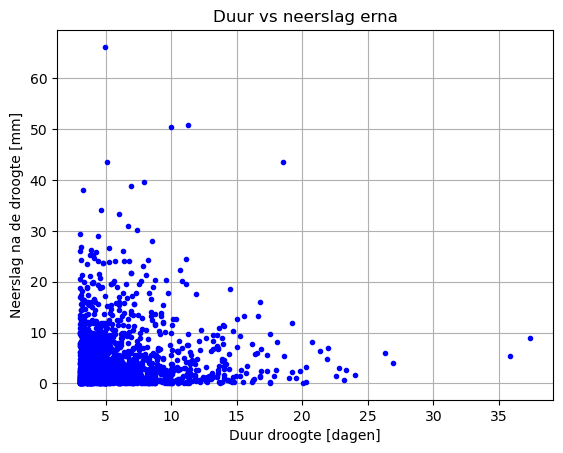

In [16]:
ax = plt.subplot()
ax.plot(resdf.Duration, resdf.Precipitation, '.', color='blue')
ax.set_xlabel('Duur droogte [dagen]')
ax.set_ylabel('Neerslag na de droogte [mm]')
ax.set_title('Duur vs neerslag erna')
ax.grid()
plt.savefig(r'figuren\droogteduur_vs_eropvolgende_neerslag.png')

Inderdaad.

## Hoeveel van de neerslag raak je kwijt als na elke droogte (> 3 dagen) de eerste 2 mm wordt weggegooid?

Maak een kopie van de resultaten en bewaaar alleen de neerslag na een droogte.

In [18]:
temp =resdf.copy(deep=True)
temp.drop(['Enddate', 'Duration'], axis=1, inplace=True)

Als de bui groter is dan 2.0 mm wordt de eerste 2.0 mm weggegooid, anders de hele bui

In [19]:
temp['Gemist'] = [p.Precipitation if p.Precipitation <= 2.0 else 2.0 for _,p in temp.iterrows()]

In [20]:
temp

,Year,Precipitation,Gemist
Enddate,,,
1958-01-31 04:00:00,1958,0.3,0.3
1958-03-02 10:00:00,1958,0.9,0.9
1958-03-05 19:00:00,1958,4.3,2.0
1958-03-20 09:00:00,1958,0.5,0.5
1958-03-26 09:00:00,1958,1.4,1.4
...,...,...,...
2023-04-20 11:00:00,2023,1.2,1.2
2023-04-28 00:00:00,2023,2.6,2.0
2023-05-05 10:00:00,2023,0.4,0.4


Bereken de jaarsommen en vergelijk het met de totale jaarsom (zie boven)

In [21]:
sommen = temp.groupby("Year").sum()[['Precipitation', 'Gemist']]
sommen['Jaarsom'] = jaarsommen
sommen['Jaarsom_rest'] = sommen['Jaarsom']  - sommen['Gemist'] 
sommen['Perc_gemist'] = (sommen['Gemist'] / sommen['Jaarsom']) * 100.

In [22]:
sommen

,Precipitation,Gemist,Jaarsom,Jaarsom_rest,Perc_gemist
Year,,,,,
1958,98.5,28.9,888.7,859.8,3.251941
1959,82.8,30.2,476.3,446.1,6.340542
1960,119.8,28.9,996.1,967.2,2.901315
1961,55.2,21.4,897.1,875.7,2.385464
1962,69.4,27.1,761.6,734.5,3.558298
...,...,...,...,...,...
2019,174.6,48.1,684.9,636.8,7.022923
2020,113.3,41.5,653.7,612.2,6.348478
2021,119.0,38.7,799.9,761.2,4.838105


In [23]:
sommen.to_csv(r'tabellen\gemiste_neerslag_per_jaar.csv', index=False, sep=",")

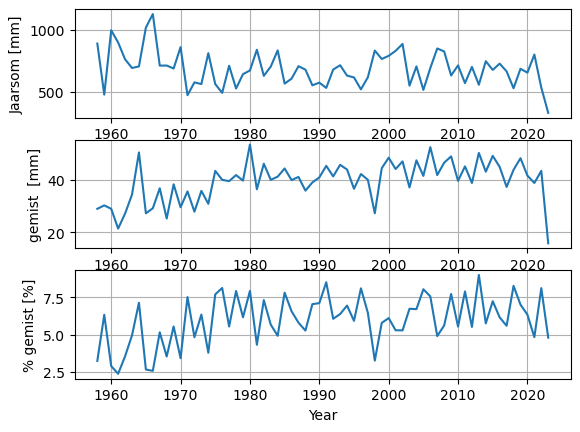

In [24]:
fig, ax = plt.subplots(3,1)
sommen['Jaarsom'].plot(ax=ax[0])
sommen['Gemist'].plot(ax=ax[1])
sommen['Perc_gemist'].plot(ax=ax[2])
ax[0].set_ylabel('Jaarsom [mm]')
ax[1].set_ylabel('gemist  [mm]')
ax[2].set_ylabel('% gemist [%]')
ax[0].grid(); ax[1].grid(); ax[2].grid()
plt.savefig(r'figuren\gemiste_neersag_per_jaar.png')

## Frequentie van voorkomen van droogtes

Bereken het maximum van elke kolom

In [28]:
maxima = resdf.groupby('Year').max()

resultaten gebaseerd op de maxima van de droogte

In [29]:
sorteddf = resdf.copy(deep=True)
sorteddf.index = sorteddf.Enddate
sorteddf = sorteddf.loc[sorteddf[['Year','Duration']].groupby('Year').idxmax()['Duration'].values]

In [30]:
sorteddf

,Enddate,Year,Duration,Precipitation
Enddate,,,,
1958-12-02 05:00:00,1958-12-02 05:00:00,1958,11.000000,0.1
1959-09-22 04:00:00,1959-09-22 04:00:00,1959,26.916667,4.0
1960-05-12 17:00:00,1960-05-12 17:00:00,1960,11.250000,50.9
1961-05-19 13:00:00,1961-05-19 13:00:00,1961,9.041667,10.4
1962-06-15 10:00:00,1962-06-15 10:00:00,1962,12.791667,1.3
...,...,...,...,...
2019-07-12 12:00:00,2019-07-12 12:00:00,2019,21.958333,7.0
2020-04-28 10:00:00,2020-04-28 10:00:00,2020,15.041667,12.6
2021-06-19 20:00:00,2021-06-19 20:00:00,2021,13.583333,6.8


In [32]:
sorteddf.to_csv(r'tabellen\max_droogteduur_perjaar_met_neerslag.csv', index=False, sep=",")

Bovenstaande tabel laat de langste droogte per jaar zien, met de eropvolgende neerslag.

Nog een check van de relatie: heeft de neerslag volgend op een droogte te maken met de lengte ervan? We plotten ze samen.

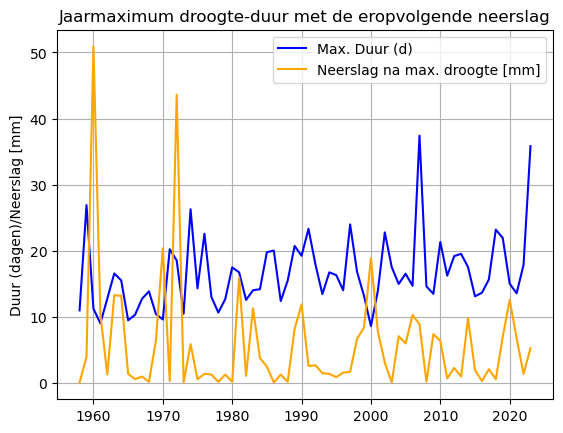

In [33]:
ax = plt.subplot()
ax.plot(sorteddf.Year, sorteddf.Duration, color='blue', label='Max. Duur (d)')
ax.plot(sorteddf.Year, sorteddf.Precipitation, color='orange', label='Neerslag na max. droogte [mm]')
ax.legend()
ax.grid()
ax.set_ylabel('Duur (dagen)/Neerslag [mm]')
ax.set_title('Jaarmaximum droogte-duur met de eropvolgende neerslag')
plt.savefig(r'figuren\tijdreeks_droogtes_opvolgendeneerslag.png')

Bepaal hoe vaak droogtes voorkomen. NB: 2007 en 2023 springen er echt uit!

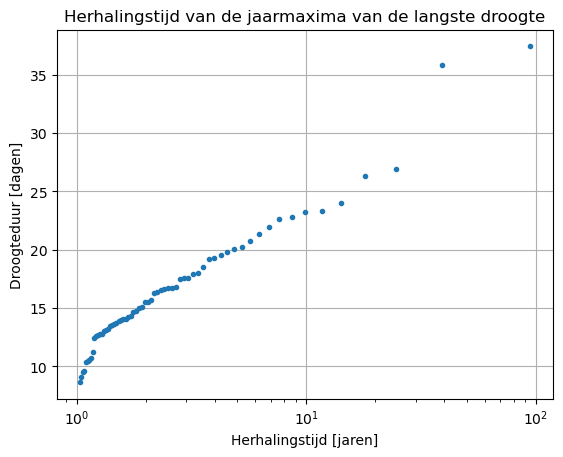

In [35]:
ht = [1./((i-0.3)/(len(sorteddf.Duration)+0.4)) for i in range(len(sorteddf.Duration))]
ax = plt.subplot()
ax.plot(ht[1:], sorted(sorteddf.Duration[1:], reverse=True), '.')
ax.semilogx()
ax.grid()
ax.set_xlabel('Herhalingstijd [jaren]')
ax.set_ylabel('Droogteduur [dagen]')
ax.set_title('Herhalingstijd van de jaarmaxima van de langste droogte')
plt.savefig(r'figuren\jaarmax_droogteduur.png')

Herhalingstijd van buien die na een droogte van tenminste een paar dagen vallen:

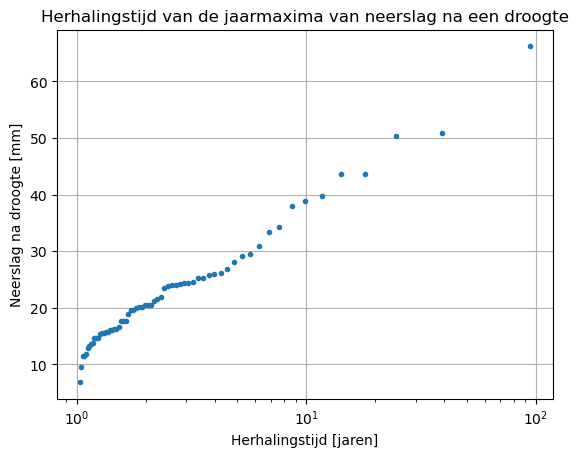

In [37]:
ht = [1./((i-0.3)/(len(maxima.Precipitation)+0.4)) for i in range(len(maxima.Precipitation))]
ax = plt.subplot()
ax.plot(ht[1:], sorted(maxima.Precipitation[1:], reverse=True), '.')
ax.semilogx()
ax.grid()
ax.set_xlabel('Herhalingstijd [jaren]')
ax.set_ylabel('Neerslag na droogte [mm]')
ax.set_title('Herhalingstijd van de jaarmaxima van neerslag na een droogte')
plt.savefig(r'figuren\jaarmax_neerslag-na-droogte.png')

In [38]:
resdf[resdf['Precipitation'] > 50]

,Enddate,Year,Duration,Precipitation
Enddate,,,,
1960-05-12 17:00:00,1960-05-12 17:00:00,1960,11.250000,50.9
1983-07-17 16:00:00,1983-07-17 16:00:00,1983,9.958333,50.4
2018-05-21 16:00:00,2018-05-21 16:00:00,2018,4.958333,66.2


## POT statistiek

Peaks over threshold: bepaal alle droogtes met een duur langer dan 2 weken; dus niet alleen het jaarmaximum.

In [39]:
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes

In [40]:
extremes = get_extremes(resdf.Duration, "POT", threshold=14, r="168H")

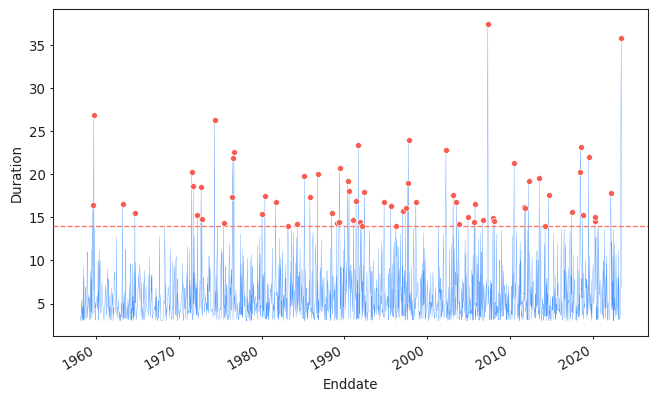

In [41]:
plot_extremes(
    ts=resdf.Duration,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=14, # ten minste 2  weken 
    r="168H",
)
plt.savefig(r'figuren\peaks_over_threshold.png')

En schat de herhalingstijd ervan.

In [42]:
return_periods = get_return_periods(
    ts=resdf.Duration,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",    
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=False).head()

,Duration,exceedance probability,return period
Enddate,,,
2007-05-07 03:00:00,37.416667,0.014286,66.358285
2023-06-20 19:00:00,35.833333,0.028571,33.179143
1959-09-22 04:00:00,26.916667,0.042857,22.119428
1974-04-23 13:00:00,26.291667,0.057143,16.589571
1997-10-07 00:00:00,24.000000,0.071429,13.271657


Plot de herhalingstijd, maar nu anders (betrouwbaarder?) geschat.

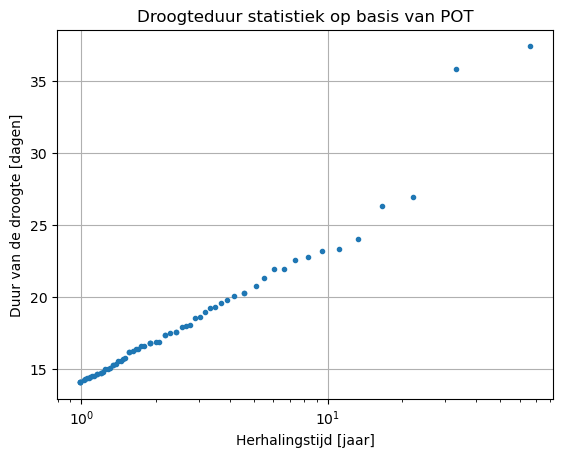

In [44]:
ax = plt.subplot()
ax.plot(return_periods['return period'], return_periods.Duration,'.')
ax.set_xlabel('Herhalingstijd [jaar]')
ax.set_ylabel('Duur van de droogte [dagen]')
ax.set_title('Droogteduur statistiek op basis van POT')
ax.semilogx()
ax.grid()
plt.savefig(r'figuren\herhalingstijd_droogteduur_pot.png')

## Conclusie

- Getallen nog finetunen
- Lange periodes van droogte vooral in het voorjaar, extremen nemen toe (op het oog)
- Periode van ~2 weken komt elk jaar wel eens voor
- Geen relatie met eropvolgende neerslag. Dat kan van alles zijn. 
